### Input_parameters

In [ ]:
file_path = 'sgc.csv'
forecast_number = 30
file_output = 'sgc_30dA.csv'
station = 'SGCachoeira_30d'

### Import_libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import gc
from pylab import rcParams

### Functions_definition

In [ ]:
def calc_metrics(a,b):
    return {'mae' : mean_absolute_error(a, b),
            'rmse' : mean_squared_error(a, b) ** 0.5,
            'r2' : r2_score(a,b),
            'mae' : mean_absolute_error(a, b)*100}
sc1 = MinMaxScaler(feature_range=(0,1))

In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Function to Calculate Result Metrics
def result_metrics_forecast(test_series,forecast_series,model_name):
    print('Result Metrics for ' +  str(model_name))
    print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
    print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
    print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

In [ ]:
def plot_result(test_series,forecast_series,model_name):
    fig = plt.figure(figsize=(20,10))
    sns.set(font_scale = 1.5)
    plt.plot (test_series.index,test_series,label='Actual')
    plt.plot (test_series.index,forecast_series,label='Predicted')
    plt.title(str(model_name) + ' - Forecasting'+' '+station)
    plt.ylabel('ALLSKy_SFC_SW_DWN - kW.h/m² (day)')
    plt.xlabel('Time - Day')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# a = original target, b = predicted_standard, c = predicted_reconv
def reconv (a,b):
    mean = np.mean(a)
    stdv = np.std(a)
    c = b * stdv + mean
    c = round(c,3)
    return c

In [ ]:
def ovft(a,b,c,d):
    o_train = mean_squared_error(a,b)
    o_test = mean_squared_error (c,d)
    if o_train > 1.25 * o_test:
        print ('No overfitting concern')
    else:
        print ('Overfitting demands attention')

In [ ]:
def data_count(df):
    # df = df.set_index("date_m", inplace = True)
    for a in df.columns:
        b =-999.0
        print(a,df[a].value_counts()[b])
    #df = df.reset_index(inplace = True)

In [ ]:
def data_replace(df):
    # df = df.set_index("date_m", inplace = True)
    for a in df.columns:
        z = df[a].median()
        print(a,z)
        b =-999.0
        df[a] = df[a].replace(b,z)
    # df = df.reset_index(inplace = True)

### Plot_parameter

In [ ]:
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

In [ ]:
gc.collect()

100

### Data_preparation

In [ ]:
df = pd.read_csv(file_path)
df[['date_m']] = df[['date_m']].apply(pd.to_datetime)
df['Year'] = df['date_m'].dt.year
df['Month'] = df['date_m'].dt.month

In [ ]:
df.head(2)

,date_m,ALLSKY_SFC_SW_DWN,ALLSKY_KT,T2M,PRECTOTCORR,RH2M,PS,WS10M,WD10M,WD50M,Year,Month
0,2013-01-01,2.77,0.28,25.57,4.34,93.75,99.79,0.6,195.00,193.31,2013,1
1,2013-01-02,4.55,0.45,25.90,3.40,92.00,99.75,0.5,194.69,190.75,2013,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741 entries, 0 to 3740
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_m             3741 non-null   datetime64[ns]
 1   ALLSKY_SFC_SW_DWN  3741 non-null   float64       
 2   ALLSKY_KT          3741 non-null   float64       
 3   T2M                3741 non-null   float64       
 4   PRECTOTCORR        3741 non-null   float64       
 5   RH2M               3741 non-null   float64       
 6   PS                 3741 non-null   float64       
 7   WS10M              3741 non-null   float64       
 8   WD10M              3741 non-null   float64       
 9   WD50M              3741 non-null   float64       
 10  Year               3741 non-null   int64         
 11  Month              3741 non-null   int64         
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 350.8 KB


In [ ]:
df1 = df[['date_m','ALLSKY_SFC_SW_DWN','ALLSKY_KT','PRECTOTCORR','WS10M','RH2M','T2M']]
df1.set_index('date_m', inplace = True)

In [ ]:
# data_count(df1)

In [ ]:
data_replace(df1)

ALLSKY_SFC_SW_DWN 4.71
ALLSKY_KT 0.45
PRECTOTCORR 4.05
WS10M 0.69
RH2M 91.94
T2M 25.74


C:\Users\aferr\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Train_test_split

In [ ]:
a = forecast_number
train = int(len(df) - a)
test = a
print(len(df), train,test)

3741 3711 30


In [ ]:
train = df1.iloc[0:3711, :]
test = df1.iloc[3711:, :]

In [ ]:
test.tail(2)

,ALLSKY_SFC_SW_DWN,ALLSKY_KT,PRECTOTCORR,WS10M,RH2M,T2M
date_m,,,,,,
2023-03-29,4.71,0.45,4.05,0.69,91.94,25.74
2023-03-30,4.71,0.45,4.05,0.69,91.94,25.74


In [ ]:
X_train, y_train = train.iloc[:, 1:6], train.iloc[:,0]
X_test, y_test = test.iloc[:, 1:6], test.iloc[:,0]

In [ ]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
X_train = pd.DataFrame(sc1.fit_transform(X_train.values), columns = X_train.columns, index = X_train.index)
X_train = round(X_train,3)
X_test = pd.DataFrame(sc1.fit_transform(X_test.values), columns = X_test.columns, index = X_test.index)
X_test = round(X_test,3)
# y_train = pd.DataFrame(sc1.fit_transform(y_train.values), columns = y_train.columns, index = y_train.index)
y_train = round(y_train,3)
# y_test = pd.DataFrame(sc1.fit_transform(y_test.values), columns = y_test.columns, index = y_test.index)
y_test = round(y_test,3)

In [ ]:
gc.collect()

218

### Model_definition: Cross_validation_MLP

In [ ]:
start = time.time()

In [ ]:
mlp_rgs = MLPRegressor(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,20,10),(10,30,10),(20,),(35,),(100,2)],
    'activation': ['tanh','relu','logistic','identity'],
    'solver': ['sgd','adam','lbfgs'],
    'alpha': [0.0001, 0.0005, 0.001, 0.05],
    'learning_rate': ['constant','invscaling','adaptive'],
}
rgs = GridSearchCV(mlp_rgs, parameter_space, n_jobs=-1, cv=5)
rgs.fit(X_train, y_train)

C:\Users\aferr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\aferr\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=100,
                                    momentum=0.9, n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_stat...
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic', 'identity'],
                         'alpha': [0.0001, 0.0005, 0.001, 0.05],
                         'hidden_layer_sizes': [(10, 20, 10), (10, 30, 10),
                                                (20,), (35,), (100, 2)

In [ ]:
print('Best parameters found:\n', rgs.best_params_)

Best parameters found:
 {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (10, 20, 10), 'learning_rate': 'invscaling', 'solver': 'adam'}


### Model_application

In [ ]:
y_pred = rgs.predict(X_test)

In [ ]:
y_test['model_pred'] = y_pred
y_test['model_pred'] = round(y_test['model_pred'],3)
y_test.loc[y_test.model_pred < 0.0, 'model_pred'] = 0
y_test['model_pred_recov'] = reconv(y_test['ALLSKY_SFC_SW_DWN'],y_test['model_pred'])
a = y_test['ALLSKY_SFC_SW_DWN']
b = y_test['model_pred']
y_test.head(2)

,ALLSKY_SFC_SW_DWN,model_pred,model_pred_recov
date_m,,,
2023-03-01,4.56,0.965,5.587
2023-03-02,6.48,1.066,5.720


In [ ]:
result_metrics_forecast(y_test['ALLSKY_SFC_SW_DWN'],y_test['model_pred_recov'],'MLP')

Result Metrics for MLP
R2 Score :  -0.679
Mean Squared Error :  2.907
Mean Absolute Error :  1.287


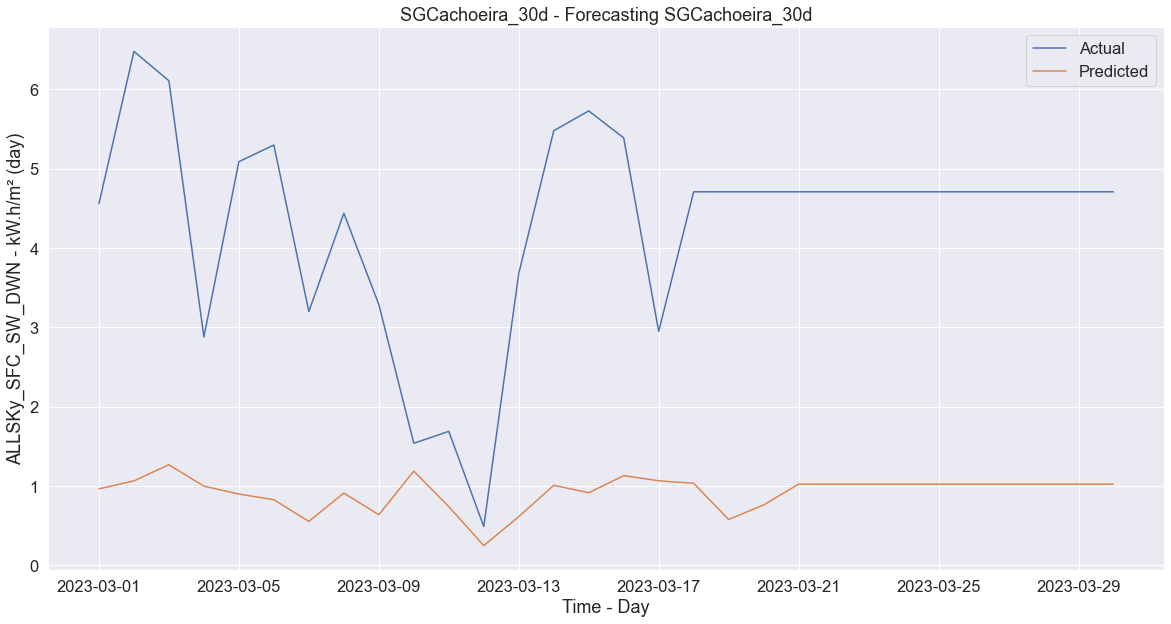

In [ ]:
plot_result(a,b,station)

In [ ]:
a = y_test['ALLSKY_SFC_SW_DWN']
b = y_test['model_pred_recov']
result_metrics = calc_metrics(a,b)
result_metrics

{'mae': 128.65666666666675,
 'rmse': 1.7048525742714533,
 'r2': -0.6787659571709879}

In [ ]:
w = round(mape(a,b),3)
w

67.21

In [ ]:
y_pred_train = rgs.predict(X_train)
ovft(y_pred_train, y_train, b, a)

Overfitting demands attention


In [ ]:
end = time.time()

In [ ]:
time_period = end - start

### Results_save

In [ ]:
Result = pd.DataFrame()
Result['Case'] = [station]
Result['R2'] = round(r2_score (a,b),3)
Result['MSE'] = round(mean_squared_error(a,b),3)
Result['MAE'] = round(mean_absolute_error(a,b),3)
Result['MAPE'] = round(w,3)
Result['time_period'] = round(time_period,3)
Result.head(2)

,Case,R2,MSE,MAE,MAPE,time_period
0,SGCachoeira_30d,-0.679,2.907,1.287,67.21,1122.393


In [ ]:
Result2= pd.DataFrame.from_dict(rgs.best_params_)
Result2

,activation,alpha,hidden_layer_sizes,learning_rate,solver
0,identity,0.001,10,invscaling,adam
1,identity,0.001,20,invscaling,adam
2,identity,0.001,10,invscaling,adam


In [ ]:
result_final = pd.concat([Result2,Result], axis = 1)

In [ ]:
result_final.head(4)

,activation,alpha,hidden_layer_sizes,learning_rate,solver,Case,R2,MSE,MAE,MAPE,time_period
0,identity,0.001,10,invscaling,adam,SGCachoeira_30d,-0.679,2.907,1.287,67.21,1122.393
1,identity,0.001,20,invscaling,adam,NaN,NaN,NaN,NaN,NaN,NaN
2,identity,0.001,10,invscaling,adam,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
result_final.to_csv(file_output, sep =',', encoding = 'utf-8')

In [ ]:
gc.collect()

5872